In [99]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import atan2
from tight_subplot import tight_subplot_2x5
from nonmax import non_max_suppression

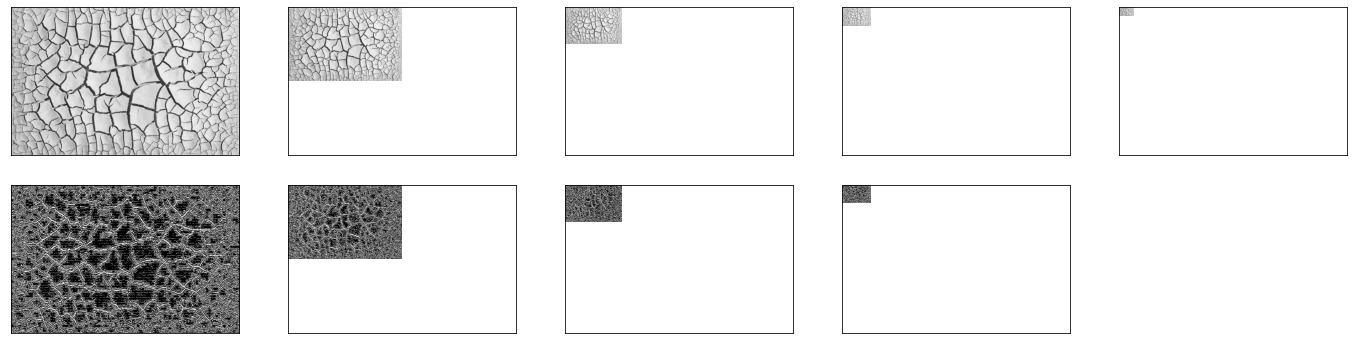

In [20]:

# Problem 1.1
img = cv2.imread('texture.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = cv2.getGaussianKernel(3, 1)
g_pyr = [img]
l_pyr = []
for i in range(1, 5):
  # apply gaussian filter
  gaussed_img = cv2.filter2D(g_pyr[i-1], -1, kernel)
  g_img_arr = np.array(gaussed_img)
  ungaussed_img_arr = np.array(g_pyr[i-1])
  # save residual i.e. diff of pre-and-post gauss blur img
  residual = np.subtract(ungaussed_img_arr, g_img_arr)
  l_pyr.append(residual)
  # remove even rows and columns
  rows = g_img_arr.shape[0]
  cols = g_img_arr.shape[1]
  g_img_arr = np.delete(g_img_arr, list(range(0, rows, 2)), axis=0)
  g_img_arr = np.delete(g_img_arr, list(range(0, cols, 2)), axis=1)
  # convert back to cv2 greyscale image (unecessary but consistent)
  downsampled_img = cv2.cvtColor(g_img_arr, cv2.COLOR_GRAY2BGR)
  g_pyr.append(g_img_arr)

tight_subplot_2x5(g_pyr, l_pyr)
plt.show()

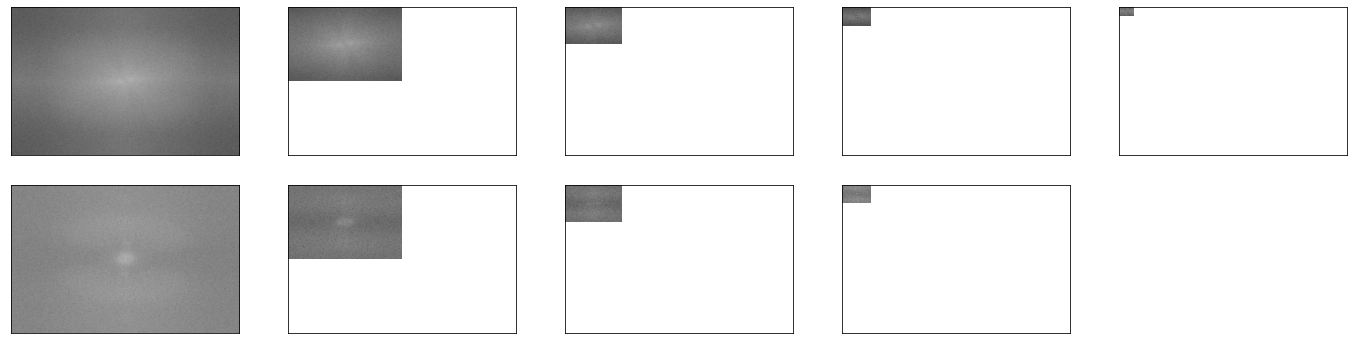

In [196]:
# Problem 1.2
g_pyr_shifted = []
l_pyr_shifted = []
for i in range(5):
  g_pyr_shifted.append(
    # isolate amplitude of the signal
    np.log(abs(
      # apply FFT to image
      np.fft.fftshift(
        np.fft.fft2(g_pyr[i])
      ))
    ))
for i in range(4):
  l_pyr_shifted.append(
    np.log(abs(
      np.fft.fftshift(
        np.fft.fft2(l_pyr[i])
      ))
    ))
# plot FFT amplitudes
tight_subplot_2x5(g_pyr_shifted, l_pyr_shifted)
plt.show()

The Gaussian filter reduces noise / high frequency components in the image. Its
Fourier shifted version has lower frequency components/less high freq. components
than the original's F-shifted plot would.

The Laplacian is just the residual difference from the original image at that level
and that level's gauss-blurred counterpart. The frequency is spread more throughout
the image, as can be seen visually on the L-pyramid's Fourier shifted plot, and
this is because high-frequency components were reduced throughout the entire image by
the Gaussian filter -- the frequencies that were reduced all over are being revealed
in the Laplacian pyramid.

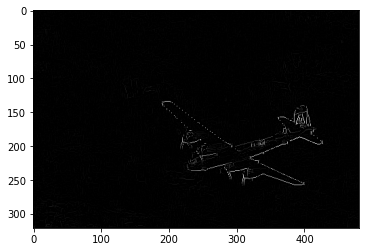

In [178]:
# Problem 2.1
def gradientMagnitude(im: np.ndarray, sigma: float):
  # split channels
  # NOTE: I chose to fully split the channels as opposed to doing
  # take_along_axis operations because I felt it was much easier to understand
  b,g,r = cv2.split(im)
  # create kernel
  kernel = cv2.getGaussianKernel(3, sigma)
  gauss_channels = []
  # gauss-blur each channel
  channels = [b, g, r]
  for c in channels:
    gauss_channels.append(cv2.filter2D(c, -1, kernel))
  # compute gradients for each g_blurred channel
  b_dx, b_dy = cv2.spatialGradient(gauss_channels[0], ksize=3, borderType=cv2.BORDER_REPLICATE)
  g_dx, g_dy = cv2.spatialGradient(gauss_channels[1], ksize=3, borderType=cv2.BORDER_REPLICATE)
  r_dx, r_dy = cv2.spatialGradient(gauss_channels[2], ksize=3, borderType=cv2.BORDER_REPLICATE)
  # convert to avoid overflow
  b_dx = b_dx.astype(np.int64)
  b_dy = b_dy.astype(np.int64)
  g_dx = g_dx.astype(np.int64)
  g_dy = g_dy.astype(np.int64)
  r_dx = r_dx.astype(np.int64)
  r_dy = r_dy.astype(np.int64)
  # L2 norm of each gradient
  """
  Why are there negative values within these sqrts?
  """
  mag_b = np.sqrt(np.square(b_dx) + np.square(b_dy))
  mag_g = np.sqrt(np.square(g_dx) + np.square(g_dy))
  mag_r = np.sqrt(np.square(r_dx) + np.square(r_dy))
  # combined magnitude
  mag = np.sqrt(np.square(mag_b) + np.square(mag_g) + np.square(mag_r))
  # compute gradient orientation at each pixel
  theta = np.ndarray(shape = mag.shape)
  for i in range(mag_b.shape[0]):
    for j in range(mag_b.shape[1]):
      if (mag_b[i][j] >= mag_g[i][j]) and (mag_b[i][j] >= mag_r[i][j]):
        # blue channel is highest magnitude
        theta[i][j] = atan2(b_dy[i][j], b_dx[i][j])
      elif (mag_g[i][j] >= mag_b[i][j]) and (mag_g[i][j] >= mag_r[i][j]):
        # green highest
        theta[i][j] = atan2(g_dy[i][j], g_dx[i][j])
      else:
        # red highest, or tie
        theta[i][j] = atan2(r_dy[i][j], r_dx[i][j])
  # print(theta)
  return mag, theta

def edgeGradient(im: np.ndarray):
  mag, theta = gradientMagnitude(im=im, sigma = 1)
  bmap = non_max_suppression(mag, theta)
  return bmap

img = cv2.imread('plane.jpg')
bmap = edgeGradient(im=img)
plt.imshow(bmap, cmap='gray')

In [ ]:
# similar to approach sent into slack by Dr. Wang: https://answers.opencv.org/question/192005/oriented-filters/
# dx = np.matrix([[-1,  0,  1]])
# dy = np.matrix([[-1],[0],[1]])
# dog_x1 = cv2.filter2D(cv2.getGaussianKernel(31,5), -1, dx)
# dog_y1 = cv2.filter2D(cv2.getGaussianKernel(31,5), -1, dy)

# rot_filt_1 = np.asarray(np.cos(np.deg2rad(angles[0])) * s_x + np.sin(np.deg2rad(angles[0])) * s_y)
# rot_filt_2 = np.cos(np.deg2rad(angles[1])) * s_x + np.sin(np.deg2rad(angles[1])) * s_y
# rot_filt_3 = np.cos(np.deg2rad(angles[2])) * s_x + np.sin(np.deg2rad(angles[2])) * s_y
# rot_filt_4 = np.cos(np.deg2rad(angles[3])) * s_x + np.sin(np.deg2rad(angles[3])) * s_y
# filter_set = np.asarray([rot_filt_1, rot_filt_2, rot_filt_3, rot_filt_4])

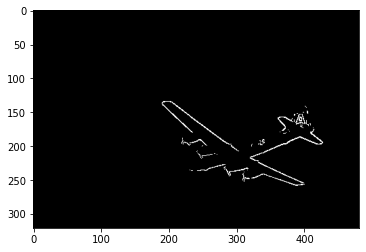

In [195]:
# Problem 2.2
def orientedFilterMagnitude(im: np.ndarray):
  s_x = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).astype(np.int64)
  s_y = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).astype(np.int64)
  angles = [45, 135, 225, 315]

  filter_set = np.ndarray(shape=[len(angles), s_x.shape[0], s_x.shape[1]])
  for i in range(len(angles)):
    filter_set[i] = np.asarray(np.cos(np.deg2rad(angles[i])) * s_x + np.sin(np.deg2rad(angles[i])) * s_y)

  filtered_imgs = []
  for filter in filter_set:
    filtered_imgs.append(cv2.filter2D(img, -1, filter))
  filtered_imgs = np.asanyarray(filtered_imgs)

  # CODE TO SHOW FILTERS & INDIVIDUAL EFFECTS
  # fig_1, axes_1 = plt.subplots(nrows=1, ncols=4, figsize=(9, 9), sharex=True, sharey=True)
  # fig_2, axes_2 = plt.subplots(nrows=1, ncols=4, figsize=(30, 8), sharex=True, sharey=True)

  # for i in range(4):
  #   axes_1[i].imshow(filter_set[i], cmap='gray')
  # for i in range(4):
  #   axes_2[i].imshow(filtered_imgs[i], cmap='gray')

  mag = np.ndarray(shape=[im.shape[0], im.shape[1]])
  theta = np.ndarray(shape=[im.shape[0], im.shape[1]])
  for i in range(len(filtered_imgs[0])):
    for j in range(len(filtered_imgs[0][0])):
      mag[i][j] = np.max(filtered_imgs[:,i,j])
      theta[i][j] = angles[np.argmax(filtered_imgs[:,i,j])]
  return mag, theta

def edgeOrientedFilters(im: np.ndarray):
  mag, theta = orientedFilterMagnitude(im=img)
  bmap = non_max_suppression(img=mag, D=theta)
  # plt.imshow(mag, cmap='gray')
  return bmap

img = cv2.imread('plane.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(edgeOrientedFilters(im=img), cmap='gray')


Problem 2.3

One method of improvement is to re-run with more orientations, e.g. one orientated filter for every 15 degrees instead of the 4 diagonals that I used at first. I re-ran the above functions with the angle set to be one for every 15 degrees, and found that boundary map to include more edges. That image is attached for comparison.

The partner of this for the nonmax suppression would be to separate the 'bins' for each angle to be more granular i.e. many smaller ranges, and use linear interpolation of adjacent gradients to come up with the gradient magnitude at each spot that is neither orthogonal nor perfectly diagonal. This would allow for more precise non-max-suppression. This should help because when the angle is rounded to aim at a directly adjacent gradient magnitude, that magnitude's pixel is more likely to actually be part of a different edge that is being 'rounded into' this edge, leading to suppressions that could be incorrect.

Combining both of these techniques would be a good way to improve both the boundary scoring, and the precision of the suppression technique.

One unrelated method that I'm not sure how to implement would incolce